In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py
import cv2

In [ ]:
import tensorflow as tf
tf.__version__
!ls "/content/drive/My Drive"

 Classroom  'Colab Notebooks'   dataset  'new dataset'


In [ ]:
from imutils import paths
IMG_PATH = "/content/drive/My Drive/dataset"
images_path = list(paths.list_images(IMG_PATH))
import os
import cv2
import numpy as np

In [ ]:
images_path

In [ ]:
def load(path):
    data = []
    labels = []
    # loop over the input image
    for (i, imgpath) in enumerate(path):
      #print(imgpath)
      gray_img = cv2.imread(imgpath)
      image = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      image = np.array(image)
      label = imgpath.split(os.path.sep)[-2]
      data.append(image)
      labels.append(label)
    # return a tuple of data and label
    return data, labels

In [ ]:
image_list, label_list = load(images_path)

In [ ]:
label_list

In [ ]:
label_list_numerical = []
for i in label_list:
    if i == 'glioma':
        label_list_numerical.append(2)
    elif i == 'meningioma':
        label_list_numerical.append(1)
    elif i == 'pituitary':
        label_list_numerical.append(3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train,Y_test = train_test_split(
    image_list, 
    label_list,
    test_size = 0.1,
    random_state = 42)

In [ ]:
import tensorflow as tf
#process and batch the test data
test_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(16)
#process and batch the train data
train_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(16)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#Use buffered prefetching to load images from disk without having I/O become blocking.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_batch.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_batch.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
#IMG_SHAPE = image_list[0].shape
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_layer.get_config()

{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense',
 'trainable': True,
 'units': 3,
 'use_bias': True}

In [ ]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = img_augmentation(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
initial_epochs = 20
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1815687684880254585
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10360021402325281373
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
history = model.fit(train_dataset, epochs=initial_epochs,validation_data=test_dataset)

Epoch 1/20
165/165 [==============================] - 39s 194ms/step - loss: 1.2531 - accuracy: 0.4993 - val_loss: 0.6343 - val_accuracy: 0.7474
Epoch 2/20
165/165 [==============================] - 32s 196ms/step - loss: 0.6741 - accuracy: 0.7275 - val_loss: 0.5046 - val_accuracy: 0.7918
Epoch 3/20
165/165 [==============================] - 32s 196ms/step - loss: 0.5266 - accuracy: 0.7889 - val_loss: 0.4870 - val_accuracy: 0.8020
Epoch 4/20
165/165 [==============================] - 32s 195ms/step - loss: 0.4950 - accuracy: 0.8126 - val_loss: 0.4655 - val_accuracy: 0.8089
Epoch 5/20
165/165 [==============================] - 32s 196ms/step - loss: 0.4744 - accuracy: 0.8315 - val_loss: 0.4391 - val_accuracy: 0.8225
Epoch 6/20
165/165 [==============================] - 32s 196ms/step - loss: 0.4217 - accuracy: 0.8409 - val_loss: 0.4239 - val_accuracy: 0.8294
Epoch 7/20
165/165 [==============================] - 32s 195ms/step - loss: 0.4174 - accuracy: 0.8437 - val_loss: 0.3929 - val_ac

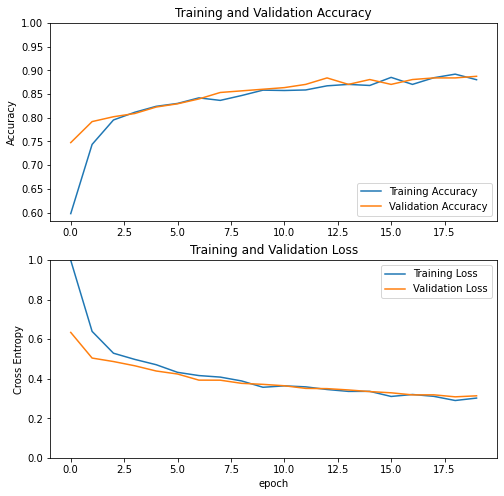

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label ='Validation Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('accuracy-loss-restnet.png')

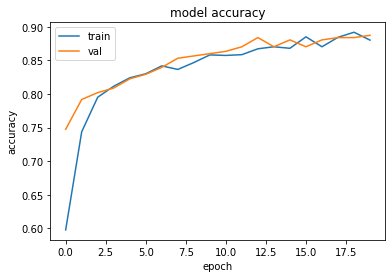

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt
#plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('accuracy_curve_restnet.png')

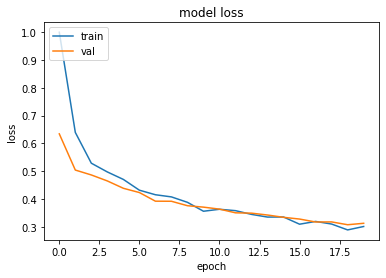

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('loss_curve_restnet.png')

In [ ]:
pred_prob = model.predict(test_dataset)
n_classes = 3
#Multiclass ROC curve
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
roc_auc

{0: 0.9757142857142858, 1: 0.9421406727828746, 2: 0.9897311827956989}

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
#compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

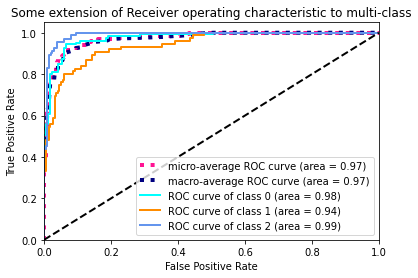

<Figure size 432x288 with 0 Axes>

In [ ]:
from itertools import cycle
# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
plt.savefig('roc-restnet.png')

In [ ]:
y_pred= np.argmax(pred_prob,axis=1)

In [ ]:
y_test = np.argmax(Y_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)

Accuracy: 0.887372


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred,average=None)
#print('Precision: %f' % precision)
precision

array([0.89393939, 0.8358209 , 0.91489362])

In [ ]:
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred, average = None)
#print('Recall: %f' % recall)
recall

array([0.944     , 0.74666667, 0.92473118])

In [ ]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred, average = None)
#print('F1 score: %f' % f1)
f1

array([0.91828794, 0.78873239, 0.9197861 ])

In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[118   5   2]
 [ 13  56   6]
 [  1   6  86]]
